## Assignment 2: Nearest Neighbours & Decision Trees

In [38]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV



## Analysis

In [39]:
raw_df = pd.read_csv("../forestCover.csv", na_values="?")
raw_df = raw_df.rename(columns={"Observation_ID":"Water_Level" , "Water_Level":"Observation_ID"})
display(raw_df)

,Elevation,Aspect,Facet,Slope,Inclination,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Observation_ID,Water_Level,Cover_Type
0,3208920,166,415.394727,6.0,0.691628,408,62,3137,225,242,...,0,0,0,0,0,0,0,2,1,2
1,2789020,137,343.302186,9.0,0.621245,30,2,1040,235,237,...,0,0,0,0,0,0,0,3,1,3
2,3384615,357,894.231390,9.0,-0.266086,362,15,3113,207,225,...,0,0,0,0,0,0,0,4,1,1
3,3348150,148,371.346939,6.0,0.786375,247,50,1207,228,240,...,0,0,0,0,0,0,0,5,1,2
4,3061955,124,310.783430,11.0,-0.335685,170,19,1595,238,232,...,0,0,0,0,0,0,0,6,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,3236545,117,293.274632,17.0,0.257413,60,0,626,247,222,...,0,0,0,0,0,0,0,581009,1,2
581008,3751475,321,805.501719,6.0,-0.479762,272,19,2906,204,234,...,0,0,0,0,0,1,0,581010,1,1
581009,2855320,72,180.453289,6.0,0.946018,0,0,1719,227,228,...,0,0,0,0,0,0,0,581011,1,6
581010,3004495,100,250.901923,7.0,0.113070,0,0,2067,231,231,...,0,0,0,0,0,0,0,581012,1,2


In [40]:
raw_df["Cover_Type"].value_counts()


Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

In [41]:
na_col = raw_df.columns[raw_df.isna().any()]
print(na_col)

Index(['Slope'], dtype='object')


In [42]:
raw_df["Slope"].isna().sum()

np.int64(298)

## Data processing
The following are data issues in the datset and need to be adressed. 
- There remain features with missing values, with missing values indicated by the character symbol `?'.
- The Facet feature is correlated with the Aspect feature.
- The Inclination feature contains only noisy values.
- There remain features with outliers.
- There remain features with numeric ranges that differ signifcantly from one another.
- There are numerical and categorical features.
- Feature Water Level has cardinality of one.
- Feature Observation ID has a unique value for each observation.
- The class distribution remains skew.

In [43]:
print(f"Corr of Inclination and Cover: {raw_df['Inclination'].corr(raw_df['Cover_Type'])}")
print(f"Corr of aspect and facet: {raw_df['Facet'].corr(raw_df['Aspect'])}")
print(f"Cardinality of water level: {raw_df['Water_Level'].nunique()}")
print(f"Cardinality of obs id: {raw_df['Observation_ID'].nunique()}")


Corr of Inclination and Cover: 0.0002417782055169697
Corr of aspect and facet: 0.9999980536139016
Cardinality of water level: 1
Cardinality of obs id: 581012


In [44]:
df = raw_df.drop(columns={'Facet','Water_Level','Observation_ID', 'Inclination' })


In [45]:
na_rows = df.index[df.isna().any(axis=1)]



na_proportions = (df["Cover_Type"][na_rows].value_counts() /  df["Cover_Type"].value_counts() * 100).round(3)
print(na_proportions)




Cover_Type
1    0.045
2    0.055
3    0.053
4    0.036
5    0.021
6    0.069
7    0.054
Name: count, dtype: float64


In [46]:
df = df.dropna()

In [47]:
df['Soil_Type1'].value_counts()

Soil_Type1
positive    577685
negative      3029
Name: count, dtype: int64

In [48]:
df["Soil_Type1"] = (df["Soil_Type1"] == 'positive').astype(int)
df["Soil_Type1"].value_counts()

Soil_Type1
1    577685
0      3029
Name: count, dtype: int64

There is little correlation between missingness and the covertype, the most missing instances are fall into class 2 which is most common, therefore we can drop na columns

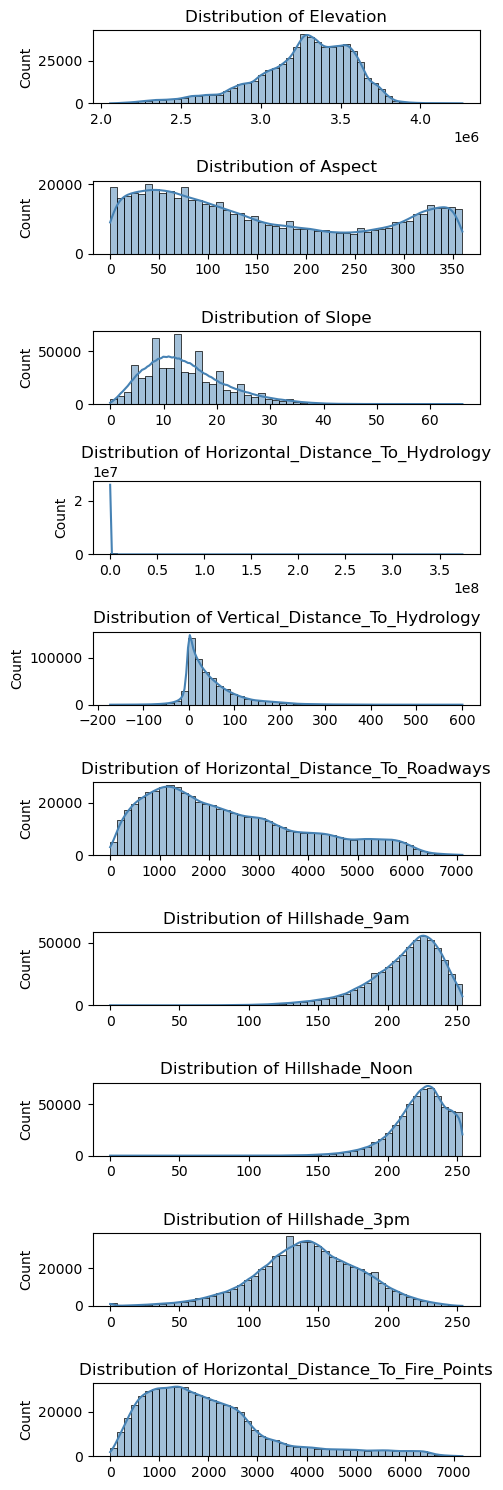

In [49]:
continuous_features = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

# Plot distributions
fig, axes = plt.subplots(len(continuous_features), 1, figsize=(5, 15))

for i, col in enumerate(continuous_features):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [50]:
df["Aspect"].describe()

count    580714.000000
mean        155.657413
std         111.914681
min           0.000000
25%          58.000000
50%         127.000000
75%         260.000000
max         360.000000
Name: Aspect, dtype: float64

## Data Augmnetation

In [51]:
df_aug = df.copy()

### PCA

In [52]:
outlier_features = [
    "Horizontal_Distance_To_Hydrology",
    "Hillshade_Noon",
    "Vertical_Distance_To_Hydrology",
]

def clamp_series(s, lower_q=0.01, upper_q=0.99):
    lower, upper = s.quantile([lower_q, upper_q])
    return s.clip(lower, upper)

# apply clamping
for col in outlier_features:
    df[col] = clamp_series(df[col], 0.01, 0.99)



continuous_features = [
    "Elevation",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]

df_pca = df.copy()

# --- Robust scaling for distance-based kNN (handles outliers better than z-score)
scaler = MinMaxScaler()
df_pca[continuous_features] = scaler.fit_transform(df_pca[continuous_features])

# --- Cyclical encoding for Aspect (DO NOT scale these)
df_pca["Aspect_rad"] = np.deg2rad(df_pca["Aspect"])
df_pca["Aspect_sin"] = np.sin(df_pca["Aspect_rad"])
df_pca["Aspect_cos"] = np.cos(df_pca["Aspect_rad"])
df_pca = df_pca.drop(columns=["Aspect", "Aspect_rad"])

# Final list for plotting

X = df_pca.drop(columns={"Cover_Type"})
y = df_pca["Cover_Type"]

In [53]:
X

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Aspect_sin,Aspect_cos
0,0.522761,0.090909,0.435432,0.354949,0.440776,0.885827,0.869565,0.594488,0.329848,1,...,0,0,0,0,0,0,0,0,0.241922,-0.970296
1,0.332666,0.136364,0.032017,0.150171,0.146129,0.925197,0.815217,0.523622,0.251499,0,...,0,0,0,0,0,0,0,0,0.681998,-0.731354
2,0.602301,0.136364,0.386339,0.194539,0.437403,0.814961,0.684783,0.614173,0.041126,1,...,0,0,0,0,0,0,0,0,-0.052336,0.998630
3,0.585793,0.090909,0.263607,0.313993,0.169594,0.897638,0.847826,0.570866,0.335285,1,...,0,0,0,0,0,0,0,0,0.529919,-0.848048
4,0.456228,0.166667,0.181430,0.208191,0.224111,0.937008,0.760870,0.488189,0.395511,1,...,0,0,0,0,0,0,0,0,0.829038,-0.559193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,0.535268,0.257576,0.064034,0.143345,0.087958,0.972441,0.652174,0.385827,0.321902,1,...,0,0,0,0,0,0,0,0,0.891007,-0.453990
581008,0.768384,0.090909,0.290288,0.208191,0.408318,0.803150,0.782609,0.665354,0.287049,1,...,0,0,0,0,0,0,1,0,-0.629320,0.777146
581009,0.362681,0.090909,0.000000,0.143345,0.241534,0.893701,0.717391,0.535433,0.407361,0,...,0,0,0,0,0,0,0,0,0.951057,0.309017
581010,0.430215,0.106061,0.000000,0.143345,0.290431,0.909449,0.750000,0.523622,0.175659,1,...,0,0,0,0,0,0,0,0,0.984808,-0.173648


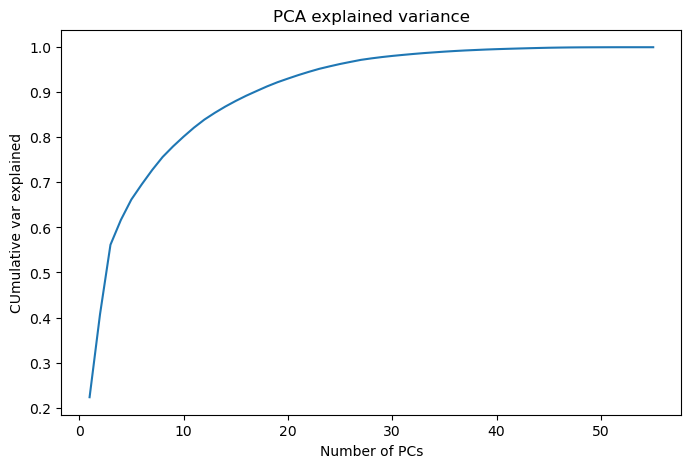

In [54]:
pca_te = PCA(n_components=None)
X_pca = pca_te.fit_transform(X)

explained_var = pca_te.explained_variance_ratio_
cum_var = explained_var.cumsum()

plt.figure(figsize=(8, 5))

plt.plot(range(1, len(explained_var)+1),cum_var )
plt.xlabel("Number of PCs")
plt.ylabel("CUmulative var explained")
plt.title("PCA explained variance")
plt.show()


In [55]:
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X)

X_pca.shape

(580714, 17)

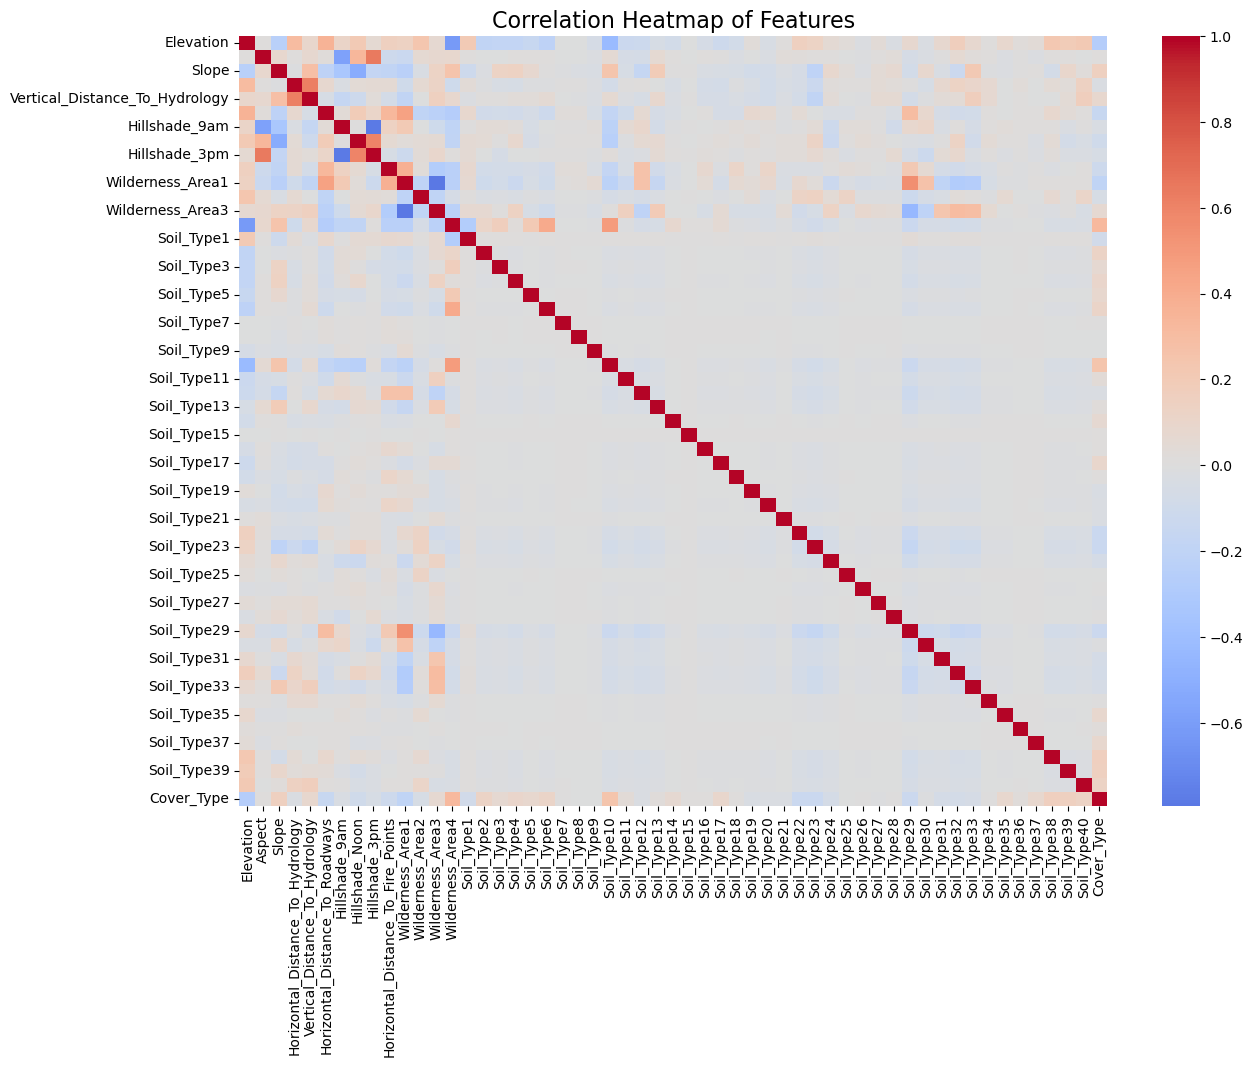

In [56]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)  # only numeric features

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f", cbar=True)

plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

## Classification Tree

In [57]:
y = df["Cover_Type"]
X = df.drop(columns="Cover_Type")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=42)

In [58]:
tomek = TomekLinks(sampling_strategy='auto')

X_train_t, y_train_t = tomek.fit_resample(X_train, y_train)

pca_X_train_t, pca_y_train_t = tomek.fit_resample(X_train_pca, y_train_pca)

c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [59]:
smote = SMOTETomek(random_state=42)

X_train_s, y_train_s = smote.fit_resample(X_train, y_train)
pca_X_train_s, pca_y_train_s = smote.fit_resample(X_train_pca, y_train_pca)


## Tomek model

entropy

In [60]:

CT_tomek = DecisionTreeClassifier( criterion = 'gini', random_state=42)
CT_tomek.fit(X_train_t, y_train_t)
CT_tomek_tr_acc = CT_tomek.score(X_train_t, y_train_t)
CT_tomek_te_acc = CT_tomek.score(X_test, y_test)

print(f"Tomek train acc: {CT_tomek_tr_acc}")
print(f"Tomek test acc: {CT_tomek_te_acc}")

Tomek train acc: 1.0
Tomek test acc: 0.9274353461771274


In [61]:
pca_X_train_t.shape

(365698, 17)

In [62]:

CT_tomek_pca = DecisionTreeClassifier( criterion = 'gini', random_state=42)
CT_tomek_pca.fit(pca_X_train_t, pca_y_train_t)
CT_tomek_tr_acc = CT_tomek_pca.score(pca_X_train_t, pca_y_train_t)
CT_tomek_te_acc = CT_tomek_pca.score(X_test_pca, y_test_pca)

print(f"Tomek train acc: {CT_tomek_tr_acc}")
print(f"Tomek test acc: {CT_tomek_te_acc}")

Tomek train acc: 1.0
Tomek test acc: 0.8529086392953308


gini

In [63]:
CT_tomek_g = DecisionTreeClassifier( criterion = 'gini', random_state=42)
CT_tomek_g.fit(X_train_t, y_train_t)
CT_tomek_tr_acc_g = CT_tomek_g.score(X_train_t, y_train_t)
CT_tomek_te_acc_g = CT_tomek_g.score(X_test, y_test)

print(f"Tomek train acc: {CT_tomek_tr_acc_g}")

print(f"Tomek test acc: {CT_tomek_te_acc_g}")

Tomek train acc: 1.0
Tomek test acc: 0.9274353461771274


In [64]:
# param_grid = {
#     "min_samples_leaf": [100, 500, 1000, 2000, 5000],
# }
# clf = DecisionTreeClassifier(random_state=42)
# grid = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
# grid.fit(X_train_t, y_train_t)

# print(grid.best_params_, grid.best_score_)

In [65]:
param_grid = {
    "max_features": ["auto", "sqrt", "log2"]
}
clf = DecisionTreeClassifier( random_state=42)
grid = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_t, y_train_t)

print(grid.best_params_, grid.best_score_)

c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File

{'max_features': 'sqrt'} 0.8761767899951963


### Smote

In [66]:
CT_smote = DecisionTreeClassifier(criterion = 'entropy',  random_state=42)
CT_smote.fit(pca_X_train_s, pca_y_train_s)
ct_sm_tr_acc = CT_smote.score(pca_X_train_s, pca_y_train_s)
ct_sm_te_acc = CT_smote.score(X_test_pca, y_test_pca)

print(f"Smote train acc: {ct_sm_tr_acc}")
print(f"Smote test acc: {ct_sm_te_acc}")

Smote train acc: 1.0
Smote test acc: 0.8573128222254691


entropy

In [67]:
CT_smote = DecisionTreeClassifier(criterion = 'entropy',  random_state=42)
CT_smote.fit(X_train_s, y_train_s)
ct_sm_tr_acc = CT_smote.score(X_train_s, y_train_s)
ct_sm_te_acc = CT_smote.score(X_test, y_test)

print(f"Smote train acc: {ct_sm_tr_acc}")
print(f"Smote test acc: {ct_sm_te_acc}")

Smote train acc: 1.0
Smote test acc: 0.9306654282076436


gini

In [68]:
CT_smote_g = DecisionTreeClassifier(criterion = 'gini', max_depth= 40, random_state=42)
CT_smote_g.fit(X_train_s, y_train_s)
ct_sm_tr_acc_g = CT_smote.score(X_train_s, y_train_s)
ct_sm_te_acc_g = CT_smote.score(X_test, y_test)

print(f"Smote train acc: {ct_sm_tr_acc_g}")
print(f"Smote test acc: {ct_sm_te_acc_g}")

Smote train acc: 1.0
Smote test acc: 0.9306654282076436


In [69]:
CT_smote_trim = DecisionTreeClassifier(criterion = 'gini', max_depth= 30, random_state=42)
CT_smote_trim.fit(X_train_s, y_train_s)
ct_sm_tr_acc = CT_smote_trim.score(X_train_s, y_train_s)
ct_sm_te_acc = CT_smote_trim.score(X_test, y_test)

print(f"Smote train acc: {ct_sm_tr_acc}")
print(f"Smote test acc: {ct_sm_te_acc}")

Smote train acc: 0.997220248280631
Smote test acc: 0.925144544866309


In [70]:
CT_smote_trim = DecisionTreeClassifier(criterion = 'gini', max_depth= 20, random_state=42)
CT_smote_trim.fit(X_train_s, y_train_s)
ct_sm_tr_acc = CT_smote_trim.score(X_train_s, y_train_s)
ct_sm_te_acc = CT_smote_trim.score(X_test, y_test)

print(f"Smote train acc: {ct_sm_tr_acc}")
print(f"Smote test acc: {ct_sm_te_acc}")

Smote train acc: 0.9638609328614232
Smote test acc: 0.8928332881087061


In [71]:
CT_smote_trim = DecisionTreeClassifier(criterion = 'gini', max_depth= 10, random_state=42)
CT_smote_trim.fit(X_train_s, y_train_s)
ct_sm_tr_acc = CT_smote_trim.score(X_train_s, y_train_s)
ct_sm_te_acc = CT_smote_trim.score(X_test, y_test)

print(f"Smote train acc: {ct_sm_tr_acc}")
print(f"Smote test acc: {ct_sm_te_acc}")

Smote train acc: 0.8072593284994924
Smote test acc: 0.6880126907261683


In [72]:
CT_smote_trim = DecisionTreeClassifier(criterion = 'gini', random_state=42)
CT_smote_trim.fit(X_train_s, y_train_s)
ct_sm_tr_acc = CT_smote_trim.score(X_train_s, y_train_s)
ct_sm_te_acc = CT_smote_trim.score(X_test, y_test)

print(f"Smote train acc: {ct_sm_tr_acc}")
print(f"Smote test acc: {ct_sm_te_acc}")

Smote train acc: 1.0
Smote test acc: 0.9266108664342817


In [73]:
param_grid = {
    "max_depth": [20, 30, 40, 50],
}
clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_s, y_train_s)

print(grid.best_params_, grid.best_score_)

c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
4 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\tree\_classes.

{'max_depth': 50} 0.9506513736622283


In [74]:
param_grid = {
    "max_features": ["auto", "sqrt", "log2"]
}
clf = DecisionTreeClassifier( random_state=42)
grid = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_s, y_train_s)

print(grid.best_params_, grid.best_score_)

c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\jamie\anaconda3\envs\datsci\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File

{'max_features': 'sqrt'} 0.9139692084040227


## Base

In [75]:
CT_base = DecisionTreeClassifier( criterion= 'entropy',  random_state=42 )
CT_base.fit(X_train, y_train)

ct_b_tr_acc = CT_smote.score(X_train, y_train)
ct_b_te_acc = CT_smote.score(X_test, y_test)

print(f"Smote train acc: {ct_b_tr_acc}")
print(f"Smote test acc: {ct_b_te_acc}")

Smote train acc: 0.9919322089658115
Smote test acc: 0.9306654282076436


In [76]:
CT_base_g = DecisionTreeClassifier( criterion= 'gini', random_state=42 )
CT_base_g.fit(X_train, y_train)

ct_b_tr_acc_g = CT_smote.score(X_train, y_train)
ct_b_te_acc_g = CT_smote.score(X_test, y_test)

print(f"Smote train acc: {ct_b_tr_acc_g}")
print(f"Smote test acc: {ct_b_te_acc_g}")

Smote train acc: 0.9919322089658115
Smote test acc: 0.9306654282076436


### KNN dataframe

In [77]:
outlier_features = [
    "Horizontal_Distance_To_Hydrology",
    "Hillshade_Noon",
    "Vertical_Distance_To_Hydrology",
]

def clamp_series(s, lower_q=0.01, upper_q=0.99):
    lower, upper = s.quantile([lower_q, upper_q])
    return s.clip(lower, upper)

# apply clamping
for col in outlier_features:
    df[col] = clamp_series(df[col], 0.01, 0.99)


In [78]:


continuous_features = [
    "Elevation",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]

knn_df = df.copy()




# --- Robust scaling for distance-based kNN (handles outliers better than z-score)
scaler = MinMaxScaler()
knn_df[continuous_features] = scaler.fit_transform(knn_df[continuous_features])

# --- Cyclical encoding for Aspect (DO NOT scale these)
knn_df["Aspect_rad"] = np.deg2rad(knn_df["Aspect"])
knn_df["Aspect_sin"] = np.sin(knn_df["Aspect_rad"])
knn_df["Aspect_cos"] = np.cos(knn_df["Aspect_rad"])
knn_df = knn_df.drop(columns=["Aspect", "Aspect_rad"])

# Final list for plotting
plot_features = continuous_features + ["Aspect_sin", "Aspect_cos"]

# # --- Plot
# n = len(plot_features)
# fig, axes = plt.subplots(n, 1, figsize=(6, 2.2*n), constrained_layout=True)

# for i, col in enumerate(plot_features):
#     sns.histplot(knn_df[col], bins=50, kde=True, ax=axes[i])
#     axes[i].set_title(f"Distribution of {col}")
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("Count")

# plt.show()

In [79]:
# knn_df.isna().any()

## Tomek links

In [80]:
y = knn_df["Cover_Type"]

# Features (everything else after preprocessing)
X = knn_df.drop(columns=["Cover_Type"])
pca_X = pca.fit_transform(X)

# Train/test split (stratify keeps class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train/test split (stratify keeps class proportions)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
    pca_X, y, test_size=0.2, random_state=42, stratify=y
)

In [81]:
# obj_cols = X_train.select_dtypes(include=['object', 'string', 'category']).columns
# print("Non-numeric columns in X_train:", list(obj_cols))
# print({c: X_train[c].unique()[:5] for c in obj_cols}) 

In [82]:
tl = TomekLinks(sampling_strategy="auto")  # "auto" = remove majority samples
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)
X_p_tr_t, y_p_tr_t = tl.fit_resample(pca_X_train, pca_y_train)
print("Before Tomek Links:", y_train.value_counts())
print("After Tomek Links:", pd.Series(y_train_tl).value_counts())

Before Tomek Links: Cover_Type
2    226515
1    169395
3     28588
7     16399
6     13884
5      7593
4      2197
Name: count, dtype: int64
After Tomek Links: Cover_Type
2    219110
1    162740
3     27325
7     15835
6     12777
5      6819
4      2197
Name: count, dtype: int64


## Modeling

In [83]:
# Initialize with some k (say 5) and Euclidean distance
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")

# Fit
knn.fit(X_train, y_train)

# Accuracy
train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9339
Test Accuracy: 0.8963


In [84]:


# Fit
knn.fit(X_train_tl, y_train_tl)

# Accuracy
train_acc = knn.score(X_train_tl, y_train_tl)
test_acc = knn.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9465
Test Accuracy: 0.8950


In [85]:

# Fit
knn.fit(X_p_tr_t, y_p_tr_t)

# Accuracy
train_acc = knn.score(X_p_tr_t, y_p_tr_t)
test_acc = knn.score(pca_X_test, pca_y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9225
Test Accuracy: 0.8492


In [ ]:


smt = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smt.fit_resample(X_train, y_train)
pca_X_smote, pca_y_smote = smt.fit_resample(pca_X_train, pca_y_train)




In [ ]:
print("Before Smote:", y_train.value_counts())
print("After Smote:", pd.Series(y_train_bal).value_counts())

Before Smote: Cover_Type
2    226515
1    169395
3     28588
7     16399
6     13884
5      7593
4      2197
Name: count, dtype: int64
After Smote: Cover_Type
4    226515
6    226470
5    226460
3    226452
7    226448
1    222051
2    221995
Name: count, dtype: int64


In [ ]:
knn_bal = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn_bal.fit(X_train_bal, y_train_bal)
train_acc = knn_bal.score(X_train_bal, X_train_bal)
test_acc = knn_bal.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9353
Test Accuracy: 0.8843


In [ ]:
knn_bal = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn_bal.fit(pca_X_smote, pca_y_smote)
train_acc = knn_bal.score(pca_X_smote, pca_y_smote)
test_acc = knn_bal.score(pca_X_test, pca_y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9741
Test Accuracy: 0.8322


In [ ]:
knn_bal = KNeighborsClassifier(n_neighbors=10, metric="euclidean")
knn_bal.fit(X_train_bal, y_train_bal)
train_acc = knn_bal.score(X_train_bal, X_train_bal)
test_acc = knn_bal.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
knn_bal = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights='distance')
knn_bal.fit(X_train_bal, y_train_bal)
train_acc = knn_bal.score(X_train_bal, X_train_bal)
test_acc = knn_bal.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
knn_bal = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights='uniform')
knn_bal.fit(X_train_bal, y_train_bal)
train_acc = knn_bal.score(X_train_bal, X_train_bal)
test_acc = knn_bal.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

## Feature Engineering

In [ ]:
df_eng = df.copy()

df_eng.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [ ]:
df_eng["ExS"] = df["Elevation"] * df["Slope"]

# Row-wise min/max/mean
df_eng["Relative_hoz_dist_min"] = df[[
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Roadways"
]].min(axis=1)

df_eng["Relative_hoz_dist_max"] = df[[
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Roadways"
]].max(axis=1)

df_eng["Relative_hoz_dist_mean"] = df[[
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Roadways"
]].mean(axis=1)

df_eng["total_hillshade"] = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].sum(axis=1)
df_eng["min_hillshade"]   = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].min(axis=1)
df_eng["max_hillshade"]   = df[["Hillshade_9am","Hillshade_Noon","Hillshade_3pm"]].max(axis=1)

df_eng["Relative_height_from_water"] = df["Elevation"] - df["Vertical_Distance_To_Hydrology"]


In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

X = df_eng.drop(columns=["Cover_Type"])
y = df_eng["Cover_Type"]

# Scale only numeric for stability
X_scaled = StandardScaler().fit_transform(X)

f_vals, p_vals = f_classif(X_scaled, y)
feature_scores = pd.Series(f_vals, index=X.columns).sort_values(ascending=False)
print(feature_scores.head(50))


Relative_height_from_water            155254.905432
Elevation                             155233.724734
Wilderness_Area4                      114553.635041
Soil_Type10                            27668.814832
Soil_Type4                             12788.671533
Soil_Type38                            12721.856165
Soil_Type39                            11906.249563
Soil_Type3                             11487.418311
Wilderness_Area1                       10372.626419
Horizontal_Distance_To_Roadways        10270.991317
Soil_Type2                             10255.681732
Soil_Type6                              8353.824003
Slope                                   7759.230522
Soil_Type40                             7341.278836
Horizontal_Distance_To_Fire_Points      7258.656756
Soil_Type1                              5127.898857
Soil_Type22                             4567.193116
Soil_Type12                             3950.415617
Soil_Type29                             3915.930873
Soil_Type17 

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_scores.head(10))


Relative_height_from_water            0.575940
Elevation                             0.458074
ExS                                   0.255471
Wilderness_Area4                      0.146108
Relative_hoz_dist_mean                0.138782
Relative_hoz_dist_max                 0.126990
Wilderness_Area1                      0.104051
Horizontal_Distance_To_Roadways       0.088951
Horizontal_Distance_To_Fire_Points    0.069865
Soil_Type10                           0.065549
dtype: float64


In [ ]:
df_eng.corr()[["ExS","Relative_hoz_dist_min","total_hillshade"]].sort_values(by="ExS")


,ExS,Relative_hoz_dist_min,total_hillshade
total_hillshade,-0.558343,0.047478,1.000000
Hillshade_Noon,-0.488036,0.044084,0.985852
min_hillshade,-0.421072,0.058303,0.765101
Hillshade_9am,-0.295756,-0.022248,-0.066720
Wilderness_Area1,-0.199908,-0.077537,0.035640
...,...,...,...
Soil_Type13,0.189326,-0.001703,0.029405
Soil_Type33,0.241960,0.100585,-0.100508
Vertical_Distance_To_Hydrology,0.301319,0.596317,-0.122367
Slope,0.968604,-0.010930,-0.596938


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))


Relative_height_from_water    0.294569
Elevation                     0.238454
Wilderness_Area4              0.174910
Relative_hoz_dist_mean        0.083812
Soil_Type22                   0.060051
Soil_Type12                   0.019042
Soil_Type38                   0.016721
Soil_Type10                   0.014579
Soil_Type23                   0.014210
Wilderness_Area2              0.013654
dtype: float64


In [ ]:
# df_eng.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [ ]:
df_eng = df_eng.drop(columns={"Elevation",  "Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Hydrology", "Horizontal_Distance_To_Fire_Points","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon", "Hillshade_3pm"  })

In [ ]:
X_eng = df_eng.drop(columns={"Cover_Type"})
y_eng = df_eng["Cover_Type"]
eng_Xtr, eng_Xte, eng_y_tr, eng_y_te = train_test_split(X_eng, y_eng, test_size=0.3, random_state=42)

In [ ]:
smote = SMOTETomek(random_state=42)

X_eng_tr_s, y_eng_tr_s =smote.fit_resample(eng_Xtr, eng_y_tr)

In [ ]:
CT_eng = DecisionTreeClassifier( criterion= 'entropy',  random_state=42 )
CT_eng.fit(X_eng_tr_s, y_eng_tr_s)

ct_b_tr_acc = CT_smote.score(X_eng_tr_s, y_eng_tr_s)
ct_b_te_acc = CT_smote.score(X_test, y_test)

print(f"Smote train acc: {ct_b_tr_acc}")
print(f"Smote test acc: {ct_b_te_acc}")

Index(['Aspect', 'Slope', 'Wilderness_Area1', 'Wilderness_Area2',
       'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type', 'Relative_hoz_dist_mean', 'total_hillshade',
       'Relative_height_from_water'],
      dtype='object')

In [ ]:


continuous_features = [

    'Slope',
    'Cover_Type', 
    'Relative_hoz_dist_mean', 
    'total_hillshade',
    'Relative_height_from_water'

]

knn_eng_df = df_eng.copy()




# --- Robust scaling for distance-based kNN (handles outliers better than z-score)
scaler = MinMaxScaler()
knn_eng_df[continuous_features] = scaler.fit_transform(knn_df[continuous_features])

# --- Cyclical encoding for Aspect (DO NOT scale these)
knn_eng_df["Aspect_rad"] = np.deg2rad(knn_eng_df["Aspect"])
knn_eng_df["Aspect_sin"] = np.sin(knn_eng_df["Aspect_rad"])
knn_eng_df["Aspect_cos"] = np.cos(knn_eng_df["Aspect_rad"])
knn_eng_df = knn_eng_df.drop(columns=["Aspect", "Aspect_rad"])

# Final list for plotting
plot_features = continuous_features + ["Aspect_sin", "Aspect_cos"]

# # --- Plot
# n = len(plot_features)
# fig, axes = plt.subplots(n, 1, figsize=(6, 2.2*n), constrained_layout=True)

# for i, col in enumerate(plot_features):
#     sns.histplot(knn_df[col], bins=50, kde=True, ax=axes[i])
#     axes[i].set_title(f"Distribution of {col}")
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("Count")

# plt.show()

In [ ]:
knn_eng_df = knn_eng_df.drop(columns={"Cover_Type"})
knn_y_eng = knn_eng_df["Cover_Type"]
eng_Xtr, eng_Xte, eng_y_tr, eng_y_te = train_test_split(X_eng, y_eng, test_size=0.3, random_state=42)

In [ ]:
knn_smote = SMOTETomek(random_state=42)

X_eng_tr_s, y_eng_tr_s =knn_smote.fit_resample(eng_Xtr, eng_y_tr)

In [ ]:
eng_knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights='distance')
eng_knn.fit(X_eng_tr_s, y_eng_tr_s)

train_acc = knn_bal.score(X_eng_tr_s, y_eng_tr_s)
test_acc = knn_bal.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")